In [149]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re, string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from zipfile import ZipFile

In [2]:
def extract(filename):
    with ZipFile(filename, 'r') as zip:
        zip.printdir()
        print("Extracting all files")
        zip.extractall()
        print("Done")
    
train_d = "../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip"
extract(train_d)

File Name                                             Modified             Size
train.csv                                      2018-01-18 16:24:16     68802655
Extracting all files
Done


In [14]:
train = pd.read_csv("train.csv")

In [4]:
train.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


<AxesSubplot:>

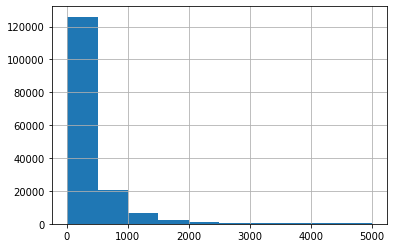

In [5]:
lens = train.comment_text.str.len()
lens.hist()

In [6]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['normal'] = 1-train[label_cols].max(axis=1)

In [7]:
train.sample(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normal
103535,29f0f5124b6c1970,"Well, before they HACK my laptop too, imma go ...",0,0,0,0,0,0,1
44446,76b3271c57c720b1,I stand by my belief that my edits were constr...,0,0,0,0,0,0,1
125829,a112306096f77700,"""\n\n Fixtures and result table. \n\nI made so...",0,0,0,0,0,0,1


In [8]:
len(train)

159571

In [73]:
train.comment_text.fillna("unknown", inplace = True)

In [74]:
train.isna().sum()

id                0
comment_text      0
toxic             0
severe_toxic      0
obscene           0
threat            0
insult            0
identity_hate     0
normal            0
comments_final    0
dtype: int64

## Lemmatization 


In [11]:
wordnet = WordNetLemmatizer()

In [12]:
def lemmatizing(word):
    capture_words = re.sub(r"[^a-zA-Z']", ' ', word)
    capture_words = capture_words.lower().split()
    remove_word = [wordnet.lemmatize(word) for word in capture_words
             if not word in set(stopwords.words('english'))]
    return ' '.join(remove_word)

In [13]:
print(train['comment_text'].iloc[1])
print(lemmatizing(train['comment_text'].iloc[1]))

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
d'aww match background colour i'm seemingly stuck thanks talk january utc


In [ ]:
train['comments_final'] = train.comment_text.apply(lemmatizing)

In [84]:
train.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,normal,comments_final
41118,6dbddce1eb35554f,I agree when he posts [] sections like this on...,0,0,0,0,0,0,1,agree post section like talk page could one ev...
131940,c20112cfd3bbcaf5,"""\nI apologize for not being more clear: Rott...",0,0,0,0,0,0,1,apologize clear rotten tomato source editorial...
4226,0b42e08f726d353f,"""\nFind such a reputable scholarly opinion, an...",0,0,0,0,0,0,1,find reputable scholarly opinion present integ...
44119,75cfeda5ea0b20b6,Re: \n\nI didn't vandalize anything. Just take...,0,0,0,0,0,0,1,vandalize anything take look edits warn notice...
5473,0e9325bced45b729,Since when is deleting a rubbish arguing vanda...,0,0,0,0,0,0,1,since deleting rubbish arguing vandalism


<AxesSubplot:>

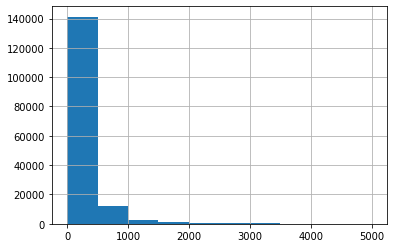

In [196]:
lens = train.comments_final.str.len()
lens.hist()

In [ ]:
train.to_csv("New.csv", index = False)

# Model Building

In [76]:
train_df, test_df = train_test_split(train, test_size = 0.3)

In [77]:
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# def tokenize(s): 
#     return re_tok.sub(r' \1 ', s).split()

In [78]:
vec = TfidfVectorizer(ngram_range=(1,2),
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [79]:
train_doc = vec.fit_transform(train_df.comments_final)
test_doc = vec.transform(test_df.comments_final)

In [80]:
train_doc, test_doc

(<111699x213762 sparse matrix of type '<class 'numpy.float64'>'
 	with 4485727 stored elements in Compressed Sparse Row format>,
 <47872x213762 sparse matrix of type '<class 'numpy.float64'>'
 	with 1837809 stored elements in Compressed Sparse Row format>)

In [100]:
x = train_doc

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)


In [94]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True, solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [103]:
models = [get_mdl(train_df[i]) for i in tqdm(label_cols)]

 17%|█▋        | 1/6 [00:06<00:31,  6.27s/it]/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
100%|██████████| 6/6 [00:49<00:00,  8.20s/it]


In [188]:
test_x = test_doc
predicts = np.zeros((len(test_df), len(label_cols)))

for i,k in tqdm(enumerate(models)): predicts[:,i] = k[0].predict_proba(test_x.multiply(k[1]))[:,1]   
    
def predict(text, thresh = .5):
    text_doc = vec.transform([text])
    predict = np.zeros((1, 6))
    for i,k in tqdm(enumerate(models)): predict[:,i] = k[0].predict_proba(text_doc.multiply(k[1]))[:,1]
    return np.where(predict >= thresh, 1, 0)

6it [00:00,  9.40it/s]


In [158]:
acc = np.where(predicts >= .7, 1, 0)

In [159]:
accuracy_score(acc, test_df.iloc[:, 2:8].values)

0.9180105280748663

In [151]:
precision_score(acc, test_df.iloc[:, 2:8].values, average='weighted')

0.5703074510072608

In [152]:
recall_score(acc, test_df.iloc[:, 2:8].values, average='weighted')

0.8801709662646924

In [195]:
predict("you are a good boy", .7)

6it [00:00, 1292.34it/s]


array([[0, 0, 0, 0, 0, 0]])